### 1. Load dataset

In [1]:
dataset_base_path = r'/Users/kripik123/Documents/dataset/processedx/'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
from catboost import Pool
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict
from scipy.stats import describe
from collections import Counter
from IPython.display import display
from time import time #time stamp for all processing time

from ml_ids.visualization import plot_hist, print_binary_performance, plot_pr_curve, plot_pr_curves, plot_pr_threshold_curves
from ml_ids.prediction import predict_proba_positive, predict_decision_boundary

%matplotlib inline

In [2]:
types = {
    'dst_port': 'uint32',
    'protocol': 'uint8',
    'timestamp': 'object',
    'flow_duration': 'int64',
    'tot_fwd_pkts': 'uint32',
    'tot_bwd_pkts': 'uint32',
    'totlen_fwd_pkts': 'uint32',
    'totlen_bwd_pkts': 'uint32',
    'fwd_pkt_len_max': 'uint16',
    'fwd_pkt_len_min': 'uint16',
    'fwd_pkt_len_mean': 'float32',
    'fwd_pkt_len_std': 'float32',
    'bwd_pkt_len_max': 'uint16',
    'bwd_pkt_len_min': 'uint16',
    'bwd_pkt_len_mean': 'float32',
    'bwd_pkt_len_std': 'float32',
    'flow_byts_s': 'float64',
    'flow_pkts_s': 'float64',
    'flow_iat_mean': 'float32',
    'flow_iat_std': 'float32',
    'flow_iat_max': 'int64',
    'flow_iat_min': 'int64',
    'fwd_iat_tot': 'int64',
    'fwd_iat_mean': 'float32',
    'fwd_iat_std': 'float32',
    'fwd_iat_max': 'int64',
    'fwd_iat_min': 'int64',
    'bwd_iat_tot': 'uint32',
    'bwd_iat_mean': 'float32',
    'bwd_iat_std': 'float32',
    'bwd_iat_max': 'uint32',
    'bwd_iat_min': 'uint32',
    'fwd_psh_flags': 'uint8',
    'bwd_psh_flags': 'uint8',
    'fwd_urg_flags': 'uint8',
    'bwd_urg_flags': 'uint8',
    'fwd_header_len': 'uint32',
    'bwd_header_len': 'uint32',
    'fwd_pkts_s': 'float32',
    'bwd_pkts_s': 'float32',
    'pkt_len_min': 'uint16',
    'pkt_len_max': 'uint16',
    'pkt_len_mean': 'float32',
    'pkt_len_std': 'float32',
    'pkt_len_var': 'float32',
    'fin_flag_cnt': 'uint8',
    'syn_flag_cnt': 'uint8',
    'rst_flag_cnt': 'uint8',
    'psh_flag_cnt': 'uint8',
    'ack_flag_cnt': 'uint8',
    'urg_flag_cnt': 'uint8',
    'cwe_flag_count': 'uint8',
    'ece_flag_cnt': 'uint8',
    'down_up_ratio': 'uint16',
    'pkt_size_avg': 'float32',
    'fwd_seg_size_avg': 'float32',
    'bwd_seg_size_avg': 'float32',
    'fwd_byts_b_avg': 'uint8',
    'fwd_pkts_b_avg': 'uint8',
    'fwd_blk_rate_avg': 'uint8',
    'bwd_byts_b_avg': 'uint8',
    'bwd_pkts_b_avg': 'uint8',
    'bwd_blk_rate_avg': 'uint8',
    'subflow_fwd_pkts': 'uint32',
    'subflow_fwd_byts': 'uint32',
    'subflow_bwd_pkts': 'uint32',
    'subflow_bwd_byts': 'uint32',
    'init_fwd_win_byts': 'int32',
    'init_bwd_win_byts': 'int32',
    'fwd_act_data_pkts': 'uint32',
    'fwd_seg_size_min': 'uint8',
    'active_mean': 'float32',
    'active_std': 'float32',
    'active_max': 'uint32',
    'active_min': 'uint32',
    'idle_mean': 'float32',
    'idle_std': 'float32',
    'idle_max': 'uint64',
    'idle_min': 'uint64',
    'label': 'category'
}

def replace_infinity_with_mean(df):
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def replace_negative_values_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values
    
    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def load_dataset(files, dtypes, cols=None):
    df = pd.concat((pd.read_csv(f, dtype=dtypes, usecols=cols) for f in files))
    
    df = replace_infinity_with_mean(df)
    df = replace_negative_values_with_mean(df)
        
    df['label_cat'] = df.label.astype('category').cat.codes
    df['label_is_attack'] = (df.label != 'Benign').astype('int')
    return df

## 2. Preprocessing Data

In [3]:
#join all csv
#split data jadi-2 X dan Y
csv_files = glob.glob(os.path.join(dataset_base_path, 'dos-*.csv'))

df = load_dataset(csv_files, types)
X = df.drop(columns=['label', 'label_cat', 'label_is_attack'])
y = df[['label_is_attack', 'label_cat', 'label']]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097149 entries, 0 to 1048574
Data columns (total 82 columns):
 #   Column             Dtype  
---  ------             -----  
 0   dst_port           uint32 
 1   protocol           uint8  
 2   timestamp          object 
 3   flow_duration      int64  
 4   tot_fwd_pkts       uint32 
 5   tot_bwd_pkts       uint32 
 6   totlen_fwd_pkts    uint32 
 7   totlen_bwd_pkts    uint32 
 8   fwd_pkt_len_max    uint16 
 9   fwd_pkt_len_min    uint16 
 10  fwd_pkt_len_mean   float32
 11  fwd_pkt_len_std    float32
 12  bwd_pkt_len_max    uint16 
 13  bwd_pkt_len_min    uint16 
 14  bwd_pkt_len_mean   float32
 15  bwd_pkt_len_std    float32
 16  flow_byts_s        float64
 17  flow_pkts_s        float64
 18  flow_iat_mean      float32
 19  flow_iat_std       float32
 20  flow_iat_max       int64  
 21  flow_iat_min       int64  
 22  fwd_iat_tot        int64  
 23  fwd_iat_mean       float32
 24  fwd_iat_std        float32
 25  fwd_iat_max       

In [6]:
#fitur yang nilainya 0 dicari 

stats = X.describe()
std = stats.loc['std']
features_no_variance = std[std == 0.0].index
pd.Series(features_no_variance).sort_values()

9    bwd_blk_rate_avg
7      bwd_byts_b_avg
8      bwd_pkts_b_avg
0       bwd_psh_flags
2       bwd_urg_flags
3      cwe_flag_count
6    fwd_blk_rate_avg
4      fwd_byts_b_avg
5      fwd_pkts_b_avg
1       fwd_urg_flags
dtype: object

In [7]:
#fitur yang nilainya 0 dihapus
X = X.drop(columns=features_no_variance)

In [5]:
#fitur timestamp dan dst_port bertipe obyek, maka dihapus saja
X = X.drop(columns=['timestamp', 'dst_port'])

### 2.1. Train / Test split

In order to train and evaluate different models a train/evaluation/test split is created with the ratios of `0.8/0.1/0.1`.  
The split is stratified using the attack category in order to guarantee that all attacks are represented in the training and test set based on their occurences in the dataset.  
To use algorithms expecting categorical values being one-hot-encoded, copies of the training and test data are created (`X_train_oh`, `X_test_oh`) with the feature `protocol` being one-hot-encoded.

In [9]:
## bagi dataset menjadi 80 % untuk training, 10 % untuk testing, 10% untuk evaluasi
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, stratify=y.label_cat)
X_eval, X_test, y_eval, y_test = train_test_split(X_hold, y_hold, test_size=0.5, stratify=y_hold.label_cat)

X_train_oh = pd.get_dummies(X_train, columns=['protocol'])
X_eval_oh = pd.get_dummies(X_eval, columns=['protocol'])
X_test_oh = pd.get_dummies(X_test, columns=['protocol'])

In [8]:
## hitung jumlah sampel per kategori di dataset
y.label.value_counts()

Benign                      1442849
DoS attacks-Hulk             461912
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
Name: label, dtype: int64

In [9]:
## hitung jumlah sampel y_train 80%
y_train.label.value_counts()

Benign                      1154279
DoS attacks-Hulk             369530
DoS attacks-SlowHTTPTest     111912
DoS attacks-GoldenEye         33206
DoS attacks-Slowloris          8792
Name: label, dtype: int64

In [10]:
## sampel testing 10%
y_test.label.value_counts()

Benign                      144285
DoS attacks-Hulk             46191
DoS attacks-SlowHTTPTest     13989
DoS attacks-GoldenEye         4151
DoS attacks-Slowloris         1099
Name: label, dtype: int64

In [11]:
## sampel evaluasi 10%
y_eval.label.value_counts()

Benign                      144285
DoS attacks-Hulk             46191
DoS attacks-SlowHTTPTest     13989
DoS attacks-GoldenEye         4151
DoS attacks-Slowloris         1099
Name: label, dtype: int64

In [18]:
## hitung persentasi antara sampel attack dengan benign di y_train
## hasilnya 68% benign, dan sisanya adalah sampel attack

percentage_benign = len(y_train.label_is_attack[y_train.label_is_attack == 0]) / len(y_train.label_is_attack)

print('Class occurences:')
print(y_train.label_is_attack.value_counts())
print('Percentage of benign samples: %.4f' % percentage_benign)

Class occurences:
0    1154279
1     523440
Name: label_is_attack, dtype: int64
Percentage of benign samples: 0.6880


## 3. Classifier

#### algoritma yang dipake sesuai Paper Qianru Zhou 
- Random forest
- Gaussian naïve bayes
- Decision tree
- MLP
- K-nn
- Quadratic discriminant analysis

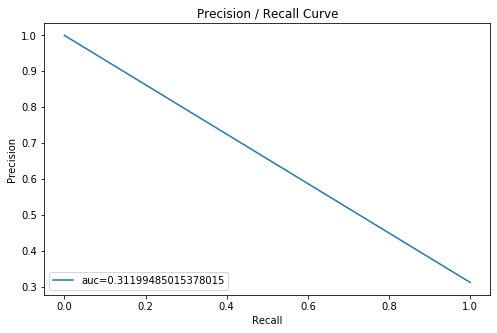

Average PR Score 0.31199485015378015
Time to fit Data Train
0:00:00.36


In [10]:
## 1. baseline clasifier (dummy clasifier)

start_time = time()
cls_dummy = DummyClassifier('most_frequent')
cls_dummy.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_dummy = predict_proba_positive(cls_dummy, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_dummy)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report:


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.688     1.000     0.815    144285
           1      0.000     0.000     0.000     65430

    accuracy                          0.688    209715
   macro avg      0.344     0.500     0.408    209715
weighted avg      0.473     0.688     0.561    209715

Confusion Matrix:


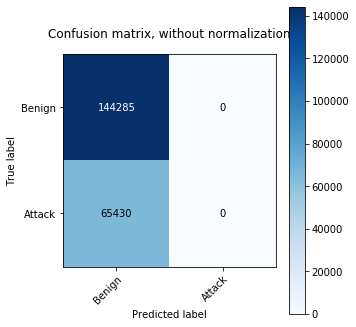

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DoS attacks-Hulk,46191,46191,1.0
DoS attacks-SlowHTTPTest,13989,13989,1.0
DoS attacks-GoldenEye,4151,4151,1.0
DoS attacks-Slowloris,1099,1099,1.0


In [11]:
## confusion matrix and missclassification table

pred_val_dummy = cls_dummy.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_dummy)

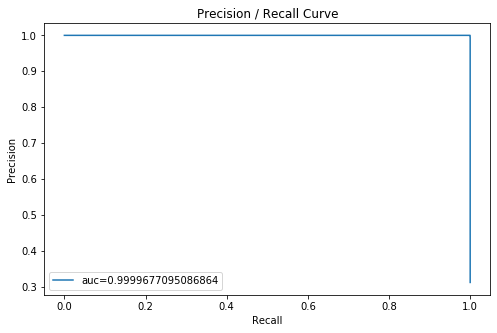

Average PR Score 0.9999677095086864
Time to fit Data Train
0:14:53.84


In [19]:
## 2. RandomForest form scikit-learn with default value
## coba dari source code binary classification

start_time = time()
##cls_forest = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced')
##cls_forest = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
cls_forest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=2, min_samples_leaf=1)
##cls_forest = RandomForestClassifier()
cls_forest.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_rf = predict_proba_positive(cls_forest, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_rf)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

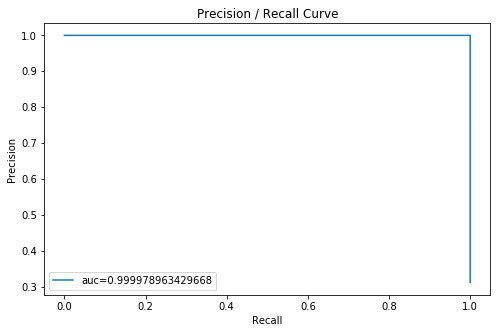

Average PR Score 0.999978963429668
Time to fit Data Train
0:26:09.28


In [10]:
## 2. RandomForest form scikit-learn with default value
## coba dari source code binary classification

start_time = time()
cls_forest = RandomForestClassifier()
cls_forest.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_rf = predict_proba_positive(cls_forest, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_rf)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000    144285
           1      1.000     1.000     1.000     65430

    accuracy                          1.000    209715
   macro avg      1.000     1.000     1.000    209715
weighted avg      1.000     1.000     1.000    209715

Confusion Matrix:


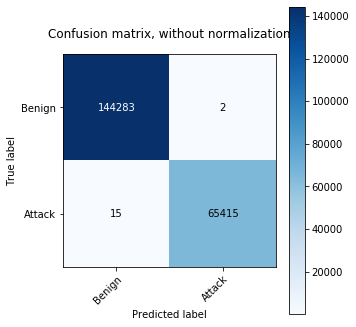

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DoS attacks-Slowloris,15,1099,0.013649
Benign,2,144285,0.000014


In [38]:
## confusion matrix and missclassification table

pred_val_rf = cls_forest.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_rf)

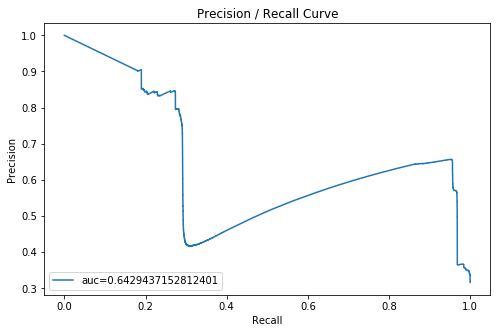

Average PR Score 0.6429437152812401


In [16]:
## 3. Gaussian Naive Bayes
start_time = time()
cls_nb = GaussianNB(priors=None, var_smoothing=1e-09)
cls_nb.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_nb = predict_proba_positive(cls_nb, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_nb)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report:
              precision    recall  f1-score   support

           0      0.971     0.192     0.320    144285
           1      0.357     0.988     0.524     65430

    accuracy                          0.440    209715
   macro avg      0.664     0.590     0.422    209715
weighted avg      0.780     0.440     0.384    209715

Confusion Matrix:


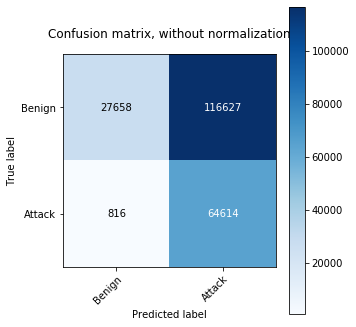

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Benign,116627,144285,0.808310
DoS attacks-GoldenEye,643,4151,0.154902
DoS attacks-Slowloris,42,1099,0.038217
DoS attacks-Hulk,131,46191,0.002836


In [18]:
pred_val_nb = cls_nb.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_nb)

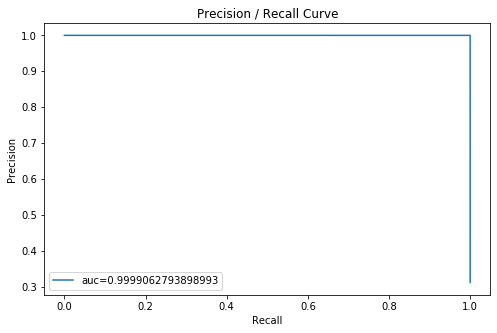

Average PR Score 0.9999062793898993
Time to fit Data Train
0:00:37.76


In [33]:
## 4. Decission Tree

start_time = time()
##cls_dt = DecisionTreeClassifier(max_depth=5,criterion="entropy")
cls_dt = DecisionTreeClassifier(splitter='best', criterion='gini', min_samples_split=2, min_samples_leaf=1)
cls_dt.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_dt = predict_proba_positive(cls_dt, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_dt)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000    144285
           1      1.000     1.000     1.000     65430

    accuracy                          1.000    209715
   macro avg      1.000     1.000     1.000    209715
weighted avg      1.000     1.000     1.000    209715

Confusion Matrix:


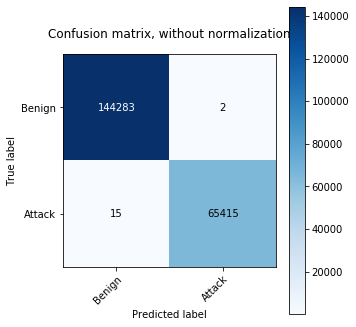

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DoS attacks-Slowloris,15,1099,0.013649
Benign,2,144285,0.000014


In [34]:
pred_val_dt = cls_dt.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_dt)

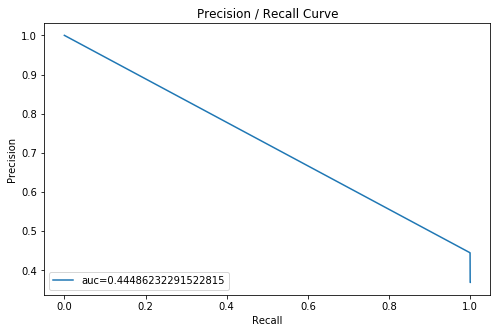

Average PR Score 0.44486232291522815


In [21]:
## 5. MLP
from sklearn.neural_network import MLPClassifier

start_time = time()
##cls_mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)
cls_mlp= MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
cls_mlp.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_mlp = predict_proba_positive(cls_mlp, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_mlp)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report:
              precision    recall  f1-score   support

           0      0.838     0.997     0.911    144285
           1      0.990     0.573     0.726     65430

    accuracy                          0.865    209715
   macro avg      0.914     0.785     0.818    209715
weighted avg      0.885     0.865     0.853    209715

Confusion Matrix:


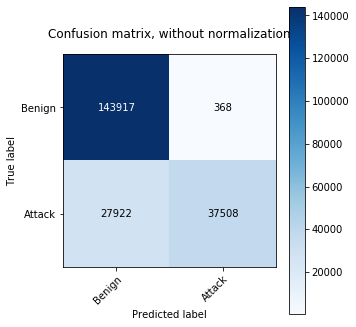

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DoS attacks-SlowHTTPTest,13989,13989,1.000000
DoS attacks-Slowloris,1099,1099,1.000000
DoS attacks-GoldenEye,4150,4151,0.999759
DoS attacks-Hulk,8684,46191,0.188002
Benign,368,144285,0.002551


In [19]:
pred_val_mlp = cls_mlp.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_mlp)

In [ ]:
## 6. KNN

start_time = time()
cls_knn = KNeighborsClassifier(n_neighbors=5,  weight='uniform', leaf_size=30, p=2, metric='minkowski')
cls_knn.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_knn = predict_proba_positive(cls_knn, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_knn)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

In [ ]:
pred_val_knn = cls_knn.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_knn)

In [ ]:
## 7. QDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

start_time = time()
cls_qda = QDA(Priors=None, reg_param=0.0)
cls_qda.fit(X_train_oh, y_train.label_is_attack)

pred_val_proba_qda = predict_proba_positive(cls_qda, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_qda)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

In [ ]:
pred_val_qda = cls_qda.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_qda)

### algoritma lainnya misalnya Log regresion --> tapi algor ini belum ada di paper IDS manapun
- Gozde Karatas (Knn, Random Forest, Gradient Boosting, Adaboost, Decision Tree, LDA)

In [ ]:
## 8. Log Regression from scikit-learn with default value
start_time = time()
##cls_lr = LogisticRegression(solver='saga', n_jobs=-1, verbose=2)
cls_lr= LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
cls_lr.fit(scaler.transform(X_train_oh), y_train.label_is_attack)

pred_val_proba_lr = predict_proba_positive(cls_lr, X_eval_oh)
plot_pr_curve(y_eval.label_is_attack.values, pred_val_proba_lr)

end_time=time()
total=end_time-start_time
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

In [ ]:
pred_val_lr = cls_lr.predict(X_eval_oh)
print_binary_performance(y_eval, y_eval.label_is_attack, pred_val_lr)

In [ ]:
## 9. Gradient Boosting form CatBoost --> opensource 
train_pool = Pool(X_train, y_train.label_is_attack, cat_features=['protocol'])
eval_pool = Pool(X_eval, y_eval.label_is_attack, cat_features=['protocol'])
test_pool = Pool(X_test, cat_features=['protocol'])

In [ ]:
start_time = time()
minority_class_weight = len(y_train[y_train.label_is_attack == 0]) / len(y_train[y_train.label_is_attack == 1])
    
cls_cb = CatBoostClassifier(loss_function='Logloss',
                            eval_metric='Recall',                        
                            class_weights=[1, minority_class_weight],
                            task_type='GPU',
                            verbose=True)

cls_cb.fit(train_pool, eval_set=eval_pool)
end_time=time()
total=end_time-start_time

In [ ]:
print_report('Train', cls_cb, train_pool, y_train.label_is_attack, cls_cb.predict(train_pool))
print_report('Eval', cls_cb, eval_pool, y_eval.label_is_attack, cls_cb.predict(eval_pool), plot_pr=True)
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

### 4.5 Model selection

Comparing the models the following results are obtained:

|Model|Recall|Precision|F1|Avg PR|Recall Attack|Precision Attack|
|-----|---------|------|--|------|-------------|----------------|
|Baseline|0.83|0.69|0.75|0.169|0.00|0.00|
|Logistic Regression|0.88|0.86|0.87|0.422|0.49|0.68|
|Random Forest|**0.99**|0.99|0.99|0.925|**0.95**|**0.96**|
|Gradient Boost|**0.99**|0.99|0.99|0.933|**0.96**|**0.97**|
|z|0.00|0.00|0.00|0|0|

Gradient Boost performed best of all models and will be used as the final estimator.